# Task 1.1

##Task 1.1

Get Data

In [1]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 

--2022-11-08 01:13:18--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  22.9MB/s    in 5.7s    

2022-11-08 01:13:23 (14.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [2]:
!tar --gunzip --extract --file=aclImdb_v1.tar.gz 

In [3]:
import pandas as pd

words_table = pd.read_csv('aclImdb/imdb.vocab', header=None)
words_table.head()

,0
0,the
1,and
2,a
3,of
4,to


In [4]:
!pip install -U libsvm-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for libsvm-official: filename=libsvm_official-3.30.0-cp37-cp37m-linux_x86_64.whl size=101395 sha256=391713c3b10d5c71035f85efc41a035abc28302caeefc34202f107b9a2ef440d
  Stored in directory: /root/.cache/pip/wheels/7a/bc/ea/af1d905b704a64fb88c9be94e00fc3d777243734e1f181ef1d
Successfully built libsvm-official


In [5]:
import numpy as np
np.random.seed(3)
words = words_table.to_numpy()
words.shape

(89527, 1)

In [6]:
valid_indices = [1 for i in range(words.shape[0])]
len(valid_indices)

89527

Remove rare and stopwords

In [7]:
import scipy
from libsvm.svmutil import *
y, x = svm_read_problem('aclImdb/train/labeledBow.feat', return_scipy = True) # y: ndarray, x: csr_matrix
appearances = (x != 0).sum(0)
ratios = appearances/y.shape[0]
valid_imdb_indices = np.where((ratios < .01) | (ratios > 0.5), False, True).flatten()
invalid_indices = np.logical_not(valid_indices)

In [8]:
valid_imdb_indices = np.array(valid_imdb_indices, dtype=bool)
valid_words = words[valid_imdb_indices, :]
X_imdb = x[:, valid_imdb_indices]
y_imdb = y
y_imdb = (y_imdb >= 5).astype(int)

Find 100 top features/words by absolute z-score 

In [9]:
from sklearn.preprocessing import StandardScaler
import math
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

scaler = StandardScaler()
x_standard = scaler.fit_transform(X_imdb.toarray())
y_standard = scaler.fit_transform(y_imdb.reshape(-1,1)).flatten()
z = (np.dot(x_standard.T, y_standard))/math.sqrt(y.shape[0])
best_features_imdb = np.argsort(abs(z))[::-1][:100]

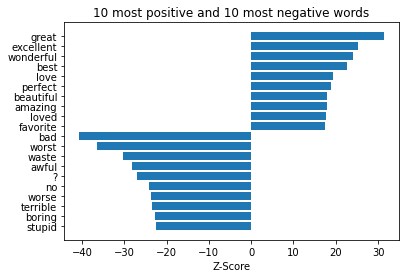

In [10]:
positive_features = np.argsort(z)[::-1][:10]
negative_features = np.argsort(z)[:10]
word_labels = list(valid_words[positive_features,0]) + list(valid_words[negative_features,0])
values = list(z[positive_features]) + list(z[negative_features])
fig, ax = plt.subplots()
y_pos = np.arange(len(word_labels))


ax.barh(y_pos, values, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(word_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Z-Score')
ax.set_title('10 most positive and 10 most negative words')

plt.show()

##Task 1.2

Getting best features from news dataset

In [11]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mutual_info_score
from heapq import heappush, heappushpop

bunch = fetch_20newsgroups(subset="train", categories=['rec.motorcycles', 'soc.religion.christian', 'sci.med', 'comp.windows.x'], remove=(['headers', 'footers', 'quotes']))
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(bunch.data)

# 4 categories:
# -------
# 1) rec.motorcycles 8
# 2) soc.religion.christian 15
# 3) sci.med 13
# 4) comp.windows.x 5

# category_indices = np.where((bunch.target == 8) | (bunch.target == 5) |(bunch.target == 15) |(bunch.target == 13), True, False).tolist()
# X_train_counts = X_train_total_counts[category_indices, :]

# One-hot Encoding
# -----------------
y_news_train = np.zeros((bunch.target.size, 4))
y_news_train[np.arange(bunch.target.size), bunch.target] = 1

ratios = ((X_train_counts != 0).sum(0))/y_news_train.shape[0]
valid_news_indices = np.where((ratios < .01) | (ratios > 0.5), False, True).flatten()
valid_news_indices = np.array(valid_news_indices, dtype=bool)

X_news = X_train_counts[:, valid_news_indices]
best_features_news = set()

for i in range(4):
  minheap = []
  for j in range(X_news.shape[1]):
    mis = mutual_info_score(y_news_train[:,i], X_news[:,j].toarray().flatten())
    if len(minheap) < 100:
      heappush(minheap, (mis,j))
    elif minheap[0][0] < mis:
      heappushpop(minheap, (mis,j))
  
  new_words = set([i for (_,i) in minheap])
  best_features_news.update(new_words)

X_news_train = X_news[:, list(best_features_news)]

In [12]:
print(bunch.target_names)

['comp.windows.x', 'rec.motorcycles', 'sci.med', 'soc.religion.christian']


#Task 2

Logistic Regression

In [13]:
logistic = lambda a: 1.0 / (1 + np.exp(-a))

class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.05, epsilon=1e-4, max_iters=1000):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        
        self.max_iters = max_iters                  

    def gradient(self, x, y):
        yh = logistic(np.dot(x, self.w))    
        grad = np.dot(x.T, yh - y)/x.shape[0]
        return grad

    def ce(self, X, y):
      a = np.dot(X, self.w)
      return np.sum(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a)))
         
    def fit(self, x, y, x_valid=None, y_valid=None):
        if x.ndim == 1:
            x = x[:, None]
            if x_valid is not None:
              x_valid = x_valid[:, None]
        if self.add_bias:
            x = np.column_stack([x,np.ones(x.shape[0])])
            if x_valid is not None:
              x_valid = np.column_stack([x_valid,np.ones(x_valid.shape[0])])
        self.w = np.array(np.zeros(x.shape[1]), dtype=np.float128)
        
        g = np.inf 
        t = 0
        self.losses = np.array([])
        if x_valid is not None and y_valid is not None:
          self.losses_valid = np.array([])
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            self.losses = np.append(self.losses, self.ce(x,y))
            if x_valid is not None and y_valid is not None:
              cost = self.ce(x_valid,y_valid)
              #print(f"iter {t}: {cost}")
              self.losses_valid = np.append(self.losses_valid, cost)
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            x = np.column_stack([x,np.ones(x.shape[0])])
        y_hat = logistic(np.dot(x,self.w))            
        return y_hat

    def check_g(self, x, y):
      N,D = x.shape
      diff = np.zeros(D+1)
      w = np.array(self.w.copy(), dtype=np.float128)

      if self.add_bias:
        x = np.column_stack([x,np.ones(x.shape[0])])

      for i in range(D+1):
        epsilon = np.zeros(D+1)
        epsilon[i] = np.random.randn(1)[0] * 1e-5
        self.w = self.w + epsilon
        ce1 = self.ce(x, y)
        self.w = w

        self.w = self.w - epsilon
        ce2 = self.ce(x, y)
        self.w = w
        
        numeric_g = (ce1 - ce2) / (2*epsilon[i])
        derived_g = self.gradient(x,y)[i]*N
        
        diff[i] = np.square(derived_g - numeric_g) / np.square(derived_g + numeric_g)
      
      return np.nansum(diff)




Training on IMDB Data

In [14]:
from sklearn import model_selection
model = LogisticRegression()

X_imdb_train, X_imdb_valid, y_imdb_train, y_imdb_valid = model_selection.train_test_split(
    X_imdb, y_imdb, test_size = 0.5, random_state=1, shuffle=True)

X_imdb_train_scaled = np.array(scaler.fit_transform(X_imdb_train[:,best_features_imdb].toarray()), dtype=np.float128)
X_imdb_valid_scaled = scaler.fit_transform(X_imdb_valid[:,best_features_imdb].toarray())
fit = model.fit(X_imdb_train_scaled, y_imdb_train, X_imdb_valid_scaled, y_imdb_valid)
optimal_imdb_iter = fit.losses_valid.argmin()
print(optimal_imdb_iter)
#Retrain model with opitmal iter
model = LogisticRegression(max_iters=optimal_imdb_iter)
X_imdb_scaled = np.array(scaler.fit_transform(X_imdb[:,best_features_imdb].toarray()), dtype=np.float128)
fit = model.fit(X_imdb_scaled, y_imdb)

602


Testing on IMDB Data

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
y_imdb_test, X_imdb_test = svm_read_problem('aclImdb/test/labeledBow.feat', return_scipy = True) # y: ndarray, x: csr_matrix
X_imdb_test = X_imdb_test[:,valid_imdb_indices]
y_imdb_pred = fit.predict(X_imdb_test[:,best_features_imdb].toarray())
y_imdb_test = (y_imdb_test >= 5).astype(int)
fpr_log, tpr_log, _ = roc_curve(y_imdb_test, y_imdb_pred)
auroc = roc_auc_score(y_imdb_test, y_imdb_pred)
auroc

0.8778829824000001

Multiclass Regression

In [16]:
class MulticlassRegression:

  def __init__(self, num_features, num_classes, learning_rate=.0005, epsilon=1e-4, max_iters=1e3):
      #populate W with values from a random sample from a uniform distribution
      self.lr = learning_rate
      self.epsilon = epsilon
      self.max_iters = math.floor(max_iters)
      self.num_features = num_features
      self.num_classes = num_classes
      self.W = np.array(np.random.rand(num_features, num_classes), dtype=np.float128)
      

  def predict(self, x):
    #compute product XW
    z = x @ self.W
    #compute soft max
    #adjust terms 
    z_max = z.max(axis=1)
    z = z - np.tile(z_max, (4, 1)).transpose()
    y_pred = np.exp(z)
    return y_pred / y_pred.sum(axis=1).reshape(x.shape[0], 1)

  def gradient(self, x, y):
    x_t = np.transpose(x)
    return x_t @ (self.predict(x) - y) 

  def cost(self, x, y):
    return -np.nansum(y * np.log(self.predict(x)))

  def fit(self, x, y, x_valid=None, y_valid=None):
    loss_train = np.array([])
    loss_valid = np.array([])
    for n in range(self.max_iters):
      g = self.gradient(x, y)
      self.W = self.W - self.lr * g
      cost = self.cost(x,y)
      loss_train = np.append(loss_train, cost)
      if x_valid is not None and y_valid is not None:
        loss_valid = np.append(loss_valid, self.cost(x_valid, y_valid))
      if np.linalg.norm(g) < self.epsilon:
        break
    
    return loss_train, loss_valid
  
  def check_grad(self, x, y):
    N, C = y.shape
    D = x.shape[1]

    diff = np.zeros((D, C))

    W = self.W.copy()

    for i in range(D):
      for j in range(C):
        epsilon = np.zeros((D, C))
        epsilon[i, j] = np.random.rand() * 1e-4

        self.W = self.W + epsilon
        J1 = self.cost(x, y)
        self.W = W

        self.W = self.W - epsilon
        J2 = self.cost(x, y)
        self.W = W

        numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
        derived_grad = self.gradient(x, y)[i, j]

        diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                      np.square(derived_grad + numeric_grad).sum()


    return diff.sum()


Training on News Dataset

In [17]:
model = MulticlassRegression(X_news_train.shape[1], y_news_train.shape[1])


X_news_train_, X_news_valid, y_news_train_, y_news_valid = model_selection.train_test_split(
    X_news_train, y_news_train, test_size = 0.5, random_state=1, shuffle=True)
X_news_train_scaled = np.array(scaler.fit_transform(X_news_train_.toarray()), dtype=np.float128)
X_news_valid_scaled = scaler.fit_transform(X_news_valid.toarray())
ce_train, ce_valid = model.fit(X_news_train_scaled, y_news_train_, X_news_valid_scaled, y_news_valid)
optimal_news_iter = ce_valid.argmin()
print(optimal_news_iter)

#Retrain model using optimal iter
model = MulticlassRegression(X_news_train.shape[1], y_news_train.shape[1], max_iters=optimal_news_iter)
X_news_train_scaled = np.array(scaler.fit_transform(X_news_train.toarray()), dtype=np.float128)
ce_train, ce_valid = model.fit(X_news_train_scaled, y_news_train)

299


Testing on News Dataset

In [18]:
bunch_test = fetch_20newsgroups(subset="test", categories=['rec.motorcycles', 'soc.religion.christian', 'sci.med', 'comp.windows.x'], remove=(['headers', 'footers', 'quotes']))
count_vect_test = CountVectorizer()
X_test_counts = count_vect_test.fit_transform(bunch_test.data)
test_words = count_vect_test.vocabulary_
valid_news_words = count_vect.get_feature_names_out()[valid_news_indices]
feature_names = valid_news_words[list(best_features_news)]
X_news_test = np.zeros((X_test_counts.shape[0], X_news_train.shape[1]))
for i in range(feature_names.shape[0]):
  if feature_names[i] in test_words:
    X_news_test[:,i] = X_test_counts[:,test_words[feature_names[i]]].toarray().flatten()

y_test_news = np.zeros((bunch_test.target.size, 4))
y_test_news[np.arange(bunch_test.target.size), bunch_test.target] = 1
y_news_pred = model.predict(X_news_test)

accuracy = sum(y_news_pred.argmax(axis=1) == y_test_news.argmax(axis=1))
accuracy = accuracy / y_test_news.shape[0]
accuracy

0.7479521109010712

In [19]:
print(bunch_test.target_names)

['comp.windows.x', 'rec.motorcycles', 'sci.med', 'soc.religion.christian']


KNN Comparison

In [20]:
from sklearn.neighbors import KNeighborsClassifier
x_imdb_test = X_imdb_test[:,best_features_imdb].toarray()

#KNN Binary Classification on IMDB dataset
knn_imdb = KNeighborsClassifier()
knn_imdb.fit(X_imdb_scaled, y_imdb)
pred = knn_imdb.predict(x_imdb_test)
imdb_score = roc_auc_score(y_imdb_test, pred)
fpr_knn, tpr_knn, _ = roc_curve(y_imdb_test, pred)

#KNN Multiclass Classification on 20-news-group dataset
knn_news = KNeighborsClassifier(1)
knn_news.fit(X_news_train, y_news_train)
news_score = knn_news.score(X_news_test, y_test_news)

print(f"IMDB auroc: {imdb_score}")
print(f"News accuracy: {news_score}")

IMDB auroc: 0.6343599999999999
News accuracy: 0.4612476370510397


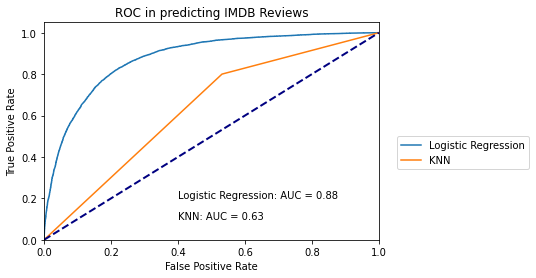

In [21]:
plt.clf()
plt.plot(fpr_log, tpr_log,label="Logistic Regression")
plt.text(0.4, 0.2, 'Logistic Regression: AUC = '+ str(round(auroc,2)))
plt.plot(fpr_knn, tpr_knn, label="KNN")
plt.text(0.4, 0.1, 'KNN: AUC = '+ str(round(imdb_score,2)))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting IMDB Reviews')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")


##Task 2.1

Gradient of Logisitic Regression Model

In [22]:
fit.check_g(X_imdb_scaled, y_imdb)

1.0805843549235597e-11

Gradient of Multiclass Regression Model

In [23]:
model.check_grad(X_news_train_scaled, y_news_train)

1.5283153478875715e-09

CE vs Iteration of Logistic Regression

Text(0.5, 1.0, 'Cross entropy vs Iteration: Logisitic Regression model on IMDB dataset ')

<Figure size 432x288 with 0 Axes>

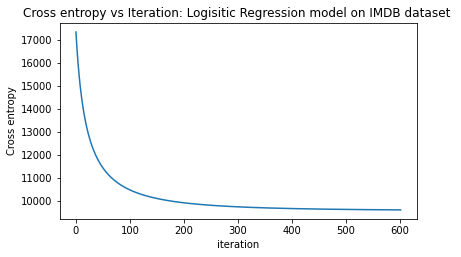

In [24]:
plt.clf()
plt.figure(figsize=((16/9)*3.6,3.6))
plt.plot(fit.losses)
plt.ylabel("Cross entropy")
plt.xlabel("iteration")
plt.title("Cross entropy vs Iteration: Logisitic Regression model on IMDB dataset ")

CE vs Iteration of Multiclass Regression Model

Text(0.5, 1.0, 'Cross entropy vs Iteration: Multiclass Regression model on 20-news-group dataset ')

<Figure size 432x288 with 0 Axes>

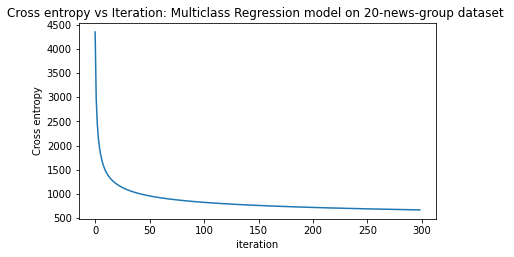

In [25]:
plt.clf()
plt.figure(figsize=((16/9)*3.6,3.6))
plt.plot(ce_train)
plt.ylabel("Cross entropy")
plt.xlabel("iteration")
plt.title("Cross entropy vs Iteration: Multiclass Regression model on 20-news-group dataset ")

#Task 3

In [26]:
auroc_labels = ['20%', '40%', '60%', '80%', '100%']
knn_auroc_values = []
logreg_auroc_values = []
for i in [.2,.4,.6,.8]:
  imdb_train_x, _, imdb_train_y, _ = model_selection.train_test_split(
      X_imdb_scaled, y_imdb, test_size=1-i, random_state=1, shuffle=True
  )
  knn = KNeighborsClassifier()
  knn.fit(imdb_train_x, imdb_train_y)
  knn_pred = knn.predict(x_imdb_test)
  knn_score = roc_auc_score(y_imdb_test, knn_pred)
  knn_auroc_values.append(knn_score)

  logreg = LogisticRegression(max_iters=optimal_imdb_iter)
  logreg.fit(imdb_train_x, imdb_train_y)
  logreg_pred = logreg.predict(x_imdb_test)
  logreg_score = roc_auc_score(y_imdb_test, logreg_pred)
  logreg_auroc_values.append(logreg_score)

knn_auroc_values.append(imdb_score)
logreg_auroc_values.append(auroc)

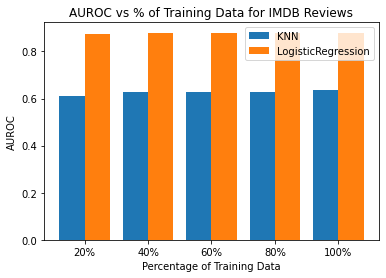

In [27]:
X_axis = np.arange(len(auroc_labels))
  
plt.bar(X_axis - 0.2, knn_auroc_values, 0.4, label = 'KNN')
plt.bar(X_axis + 0.2, logreg_auroc_values, 0.4, label = 'LogisticRegression')
  
plt.xticks(X_axis, auroc_labels)
plt.xlabel("Percentage of Training Data")
plt.ylabel("AUROC")
plt.title("AUROC vs % of Training Data for IMDB Reviews")
plt.legend()
plt.show()

In [28]:
knn_acc_values = []
multireg_acc_values = []
for i in [.2,.4,.6,.8]:
  news_train_x, _, news_train_y, _ = model_selection.train_test_split(
      X_news_train, y_news_train, test_size=1-i, random_state=1, shuffle=True
  )
  knn = KNeighborsClassifier()
  knn.fit(news_train_x, news_train_y)
  knn_pred = knn_imdb.predict(x_imdb_test)
  knn_news_score = knn.score(X_news_test, y_test_news)
  knn_acc_values.append(knn_news_score)

  multireg = MulticlassRegression(news_train_x.shape[1], news_train_y.shape[1], max_iters=optimal_news_iter)
  multireg.fit(news_train_x, news_train_y)
  multireg_pred = multireg.predict(X_news_test)
  multireg_acc = sum(multireg_pred.argmax(axis=1) == y_test_news.argmax(axis=1)) / y_test_news.shape[0]
  multireg_acc_values.append(multireg_acc)
  

knn_acc_values.append(news_score)
multireg_acc_values.append(accuracy)

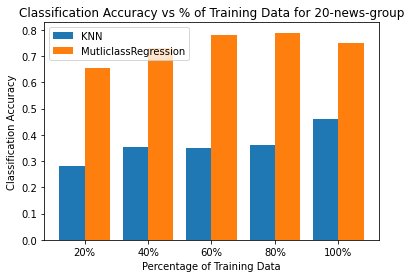

In [29]:
X_axis = np.arange(len(auroc_labels))
  
plt.bar(X_axis - 0.2, knn_acc_values, 0.4, label = 'KNN')
plt.bar(X_axis + 0.2, multireg_acc_values, 0.4, label = 'MutliclassRegression')
  
plt.xticks(X_axis, auroc_labels)
plt.xlabel("Percentage of Training Data")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy vs % of Training Data for 20-news-group")
plt.legend()
plt.show()

(1744, 1)


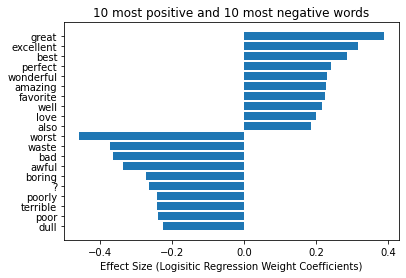

In [30]:
weights = fit.w[:len(fit.w)-1]
positive_features = np.argsort(weights)[::-1][:10]
negative_features = np.argsort(weights)[:10]
print(valid_words.shape)
valid_words_bf = valid_words[best_features_imdb] 
word_labels = list(valid_words_bf[positive_features,0]) + list(valid_words_bf[negative_features,0])
values = list(weights[positive_features]) + list(weights[negative_features])
fig, ax = plt.subplots()
y_pos = np.arange(len(word_labels))


ax.barh(y_pos, values, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(word_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Effect Size (Logisitic Regression Weight Coefficients)')
ax.set_title('10 most positive and 10 most negative words')
plt.show()

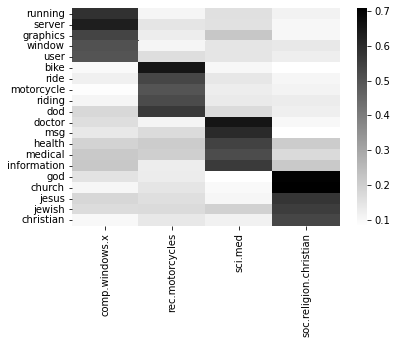

In [31]:
best_feature_indicies = np.array(np.zeros((4,5)),dtype=int)
for i in range(4):
  best_feature_indicies[i,:] = np.argsort(model.W[:,i], axis=0)[::-1][:5]
best_feature_names = feature_names[best_feature_indicies]
W_hat = model.W[best_feature_indicies]
W_hat_transformed = np.exp(W_hat)
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=0)[None,:]

W_hat_transformed_df = pd.DataFrame(W_hat_transformed.reshape(20,4), columns=bunch.target_names, index=best_feature_names.flatten())
from seaborn import heatmap
hmp = heatmap(W_hat_transformed_df, cmap='gray_r')
fig = hmp.get_figure()